# Anomaly Detection

Imports:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

Data:

In [2]:
taxi = pd.read_csv('nyc_taxi.csv',index_col=[0], parse_dates=[0])
taxi.head()

,value
timestamp,
2014-07-01 00:00:00,10844
2014-07-01 00:30:00,8127
2014-07-01 01:00:00,6210
2014-07-01 01:30:00,4656
2014-07-01 02:00:00,3820


# Feature Engineering & Visualizations

Lets first get some statistics about our value which we may use later to detect our anomalies:

In [3]:
taxiCount = taxi['value']
taxiCount.describe()

count    10320.000000
mean     15137.569380
std       6939.495808
min          8.000000
25%      10262.000000
50%      16778.000000
75%      19838.750000
max      39197.000000
Name: value, dtype: float64

This data would be more useful if it allowed me to see how many standard deviations away each value was from the mean value of taxi rides ordered. I will create a new column to serve this purpose.

In [4]:
taxi['stdFromMean'] = taxi.apply(lambda row: ((row.value - 
                                  (15137)) / 6939), axis = 1)
taxi.head()

,value,stdFromMean
timestamp,,
2014-07-01 00:00:00,10844,-0.618677
2014-07-01 00:30:00,8127,-1.010232
2014-07-01 01:00:00,6210,-1.286497
2014-07-01 01:30:00,4656,-1.510448
2014-07-01 02:00:00,3820,-1.630927


I want to chart my data in a way that makes these anomalies easy to see. I will use a box plot to chart value (number of taxis) because box plots show their outliars.

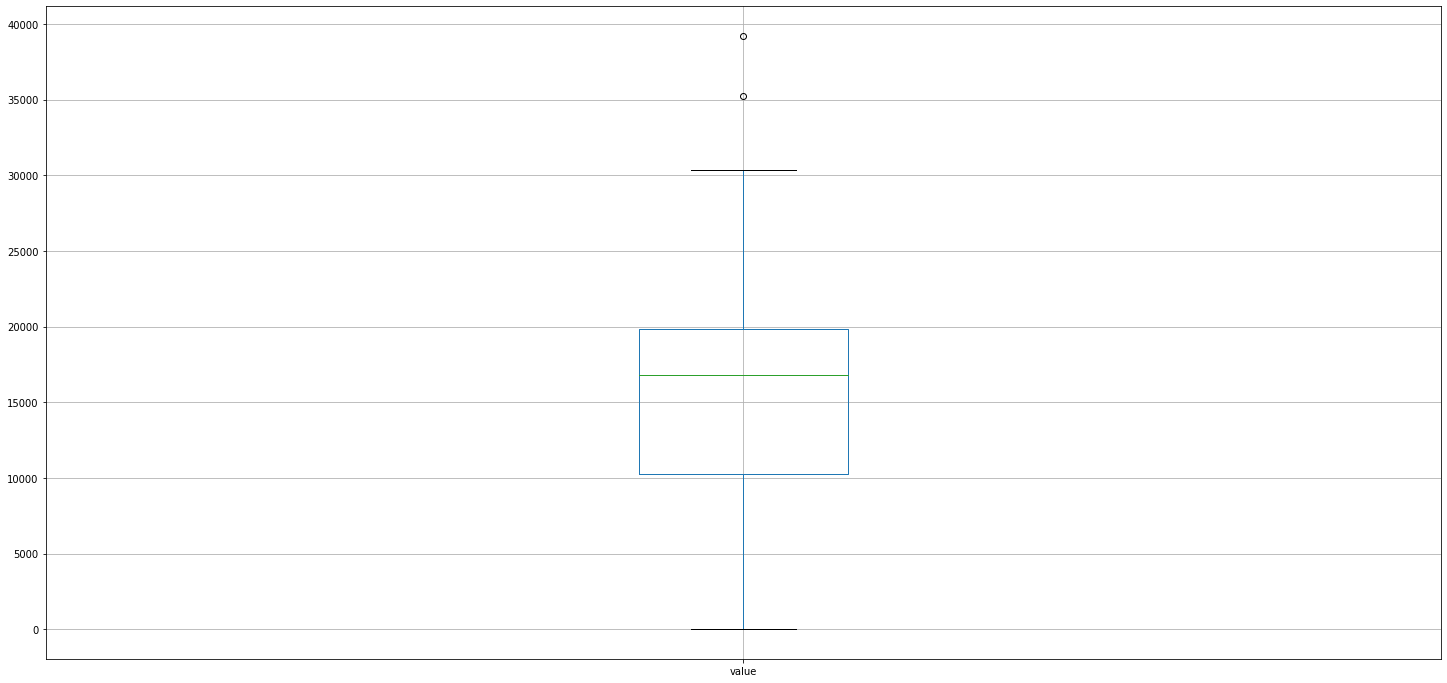

In [5]:
plt.figure(figsize = (25,12))
boxplot = taxi.boxplot(column=['value'])

This box plot only reveals 2 of my anomalies, so I will need to find a new way to represent my data. I will now see if my data follows a normal distribution by visualizing it in 2 new ways.

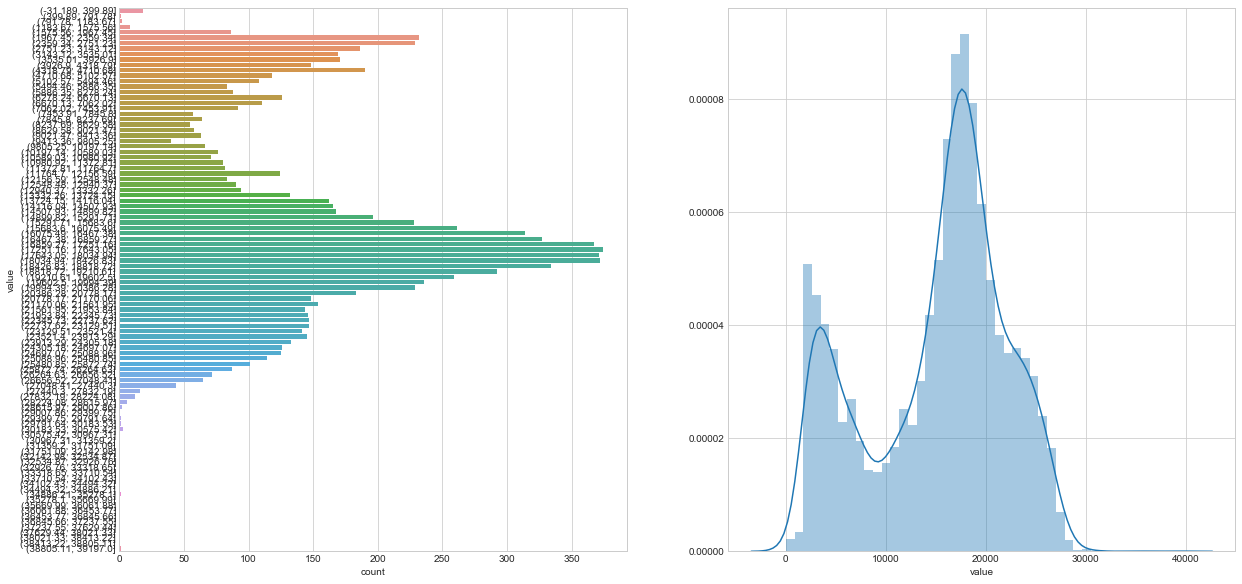

In [6]:
data_bin = pd.DataFrame()
data_con = pd.DataFrame()

data_bin['value'] = pd.cut(taxi['value'], 100)
data_con['value'] = taxi['value']

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize = (20, 10)) 
plt.subplot(1, 2, 1)
sns.countplot(y = "value", data = data_bin);
plt.subplot(1, 2, 2)
sns.distplot(data_con["value"]);

It is clear from the above data that my data set follows a bimodal distribution with centers around 3,000 and 17,000 taxi rides requested per half hour. I must now consider the fact that this is actually a time series. This matters because perhaps an anomaly occurs based on the time of day, not overall amount of traffic. For example, a huge number of taxi's called in the middle of the day would not be detected as anomalies in this model because that number falls in a normal range of taxis for rush hour. I will now plot taxi's called vs their timestamp:

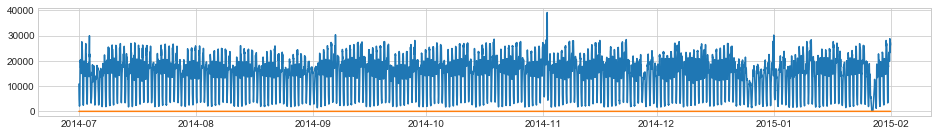

In [7]:
register_matplotlib_converters()
plt.figure(figsize=(16,2))
plt.plot(taxi)

I can clearly see a pattern in this data set, one that appears to occur each month. Let's zoom in on a particular month, I'll pick October of 2014 because it doesnt appear to have any huge jumps.

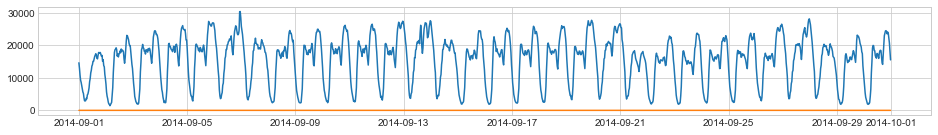

In [8]:
aug = taxi.loc[taxi.loc[taxi.index < "2014-10-01"].index >= "2014-09-01"]
plt.figure(figsize=(16,2))
plt.plot(aug)

It appears that each week has a pattern, lets zoom in further to see if there is a pattern between weeks/ weekdays.

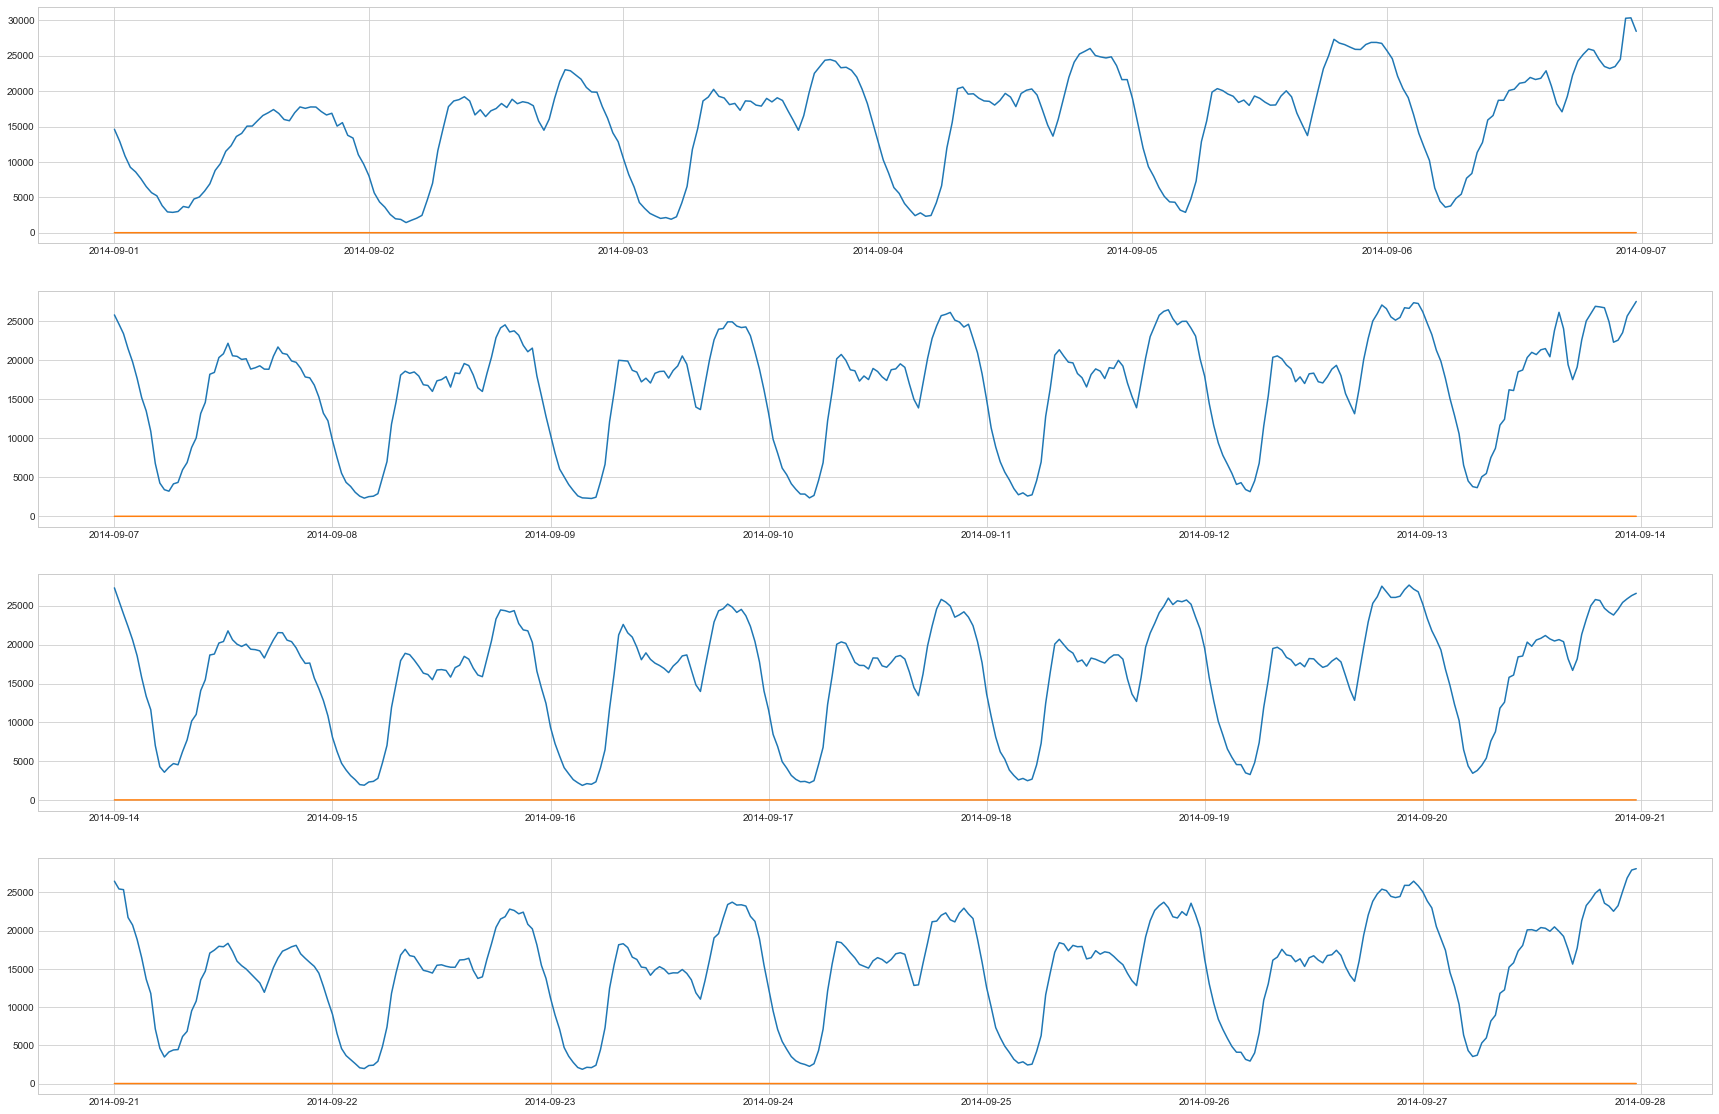

In [9]:
week1 = taxi.loc[taxi.loc[taxi.index < "2014-09-07"].index >= "2014-09-01"]
week2 = taxi.loc[taxi.loc[taxi.index < "2014-09-14"].index >= "2014-09-07"]
week3 = taxi.loc[taxi.loc[taxi.index < "2014-09-21"].index >= "2014-09-14"]
week4 = taxi.loc[taxi.loc[taxi.index < "2014-09-28"].index >= "2014-09-21"]
plt.figure(figsize=(30,20))
plt.subplot(411)
plt.plot(week1)
plt.subplot(412)
plt.plot(week2)
plt.subplot(413)
plt.plot(week3)
plt.subplot(414)
plt.plot(week4)

Now I see a clear pattern based on day of the week, and time of day. These two humps would make sense as they might correspond to morning and evening rush hour traffic. Because of this pattern, I will now break apart the timestamps into day and time and add them back into my table.

In [10]:
taxi['Weekday'] = taxi.index.map(lambda s : s.weekday())
taxi['Time'] = taxi.index - taxi.index.map(lambda s : s.floor(freq ='D'))
taxi['Time'] = taxi.Time.map(lambda s : s.value/60/60/1000000000)
taxi.head()

,value,stdFromMean,Weekday,Time
timestamp,,,,
2014-07-01 00:00:00,10844,-0.618677,1,0.0
2014-07-01 00:30:00,8127,-1.010232,1,0.5
2014-07-01 01:00:00,6210,-1.286497,1,1.0
2014-07-01 01:30:00,4656,-1.510448,1,1.5
2014-07-01 02:00:00,3820,-1.630927,1,2.0


I have now seen that the standard deviations from mean are meaningless because they do not take time into account. I will therefor remove them.

In [11]:
taxi = taxi.drop(columns=['stdFromMean'])
taxi.head()

,value,Weekday,Time
timestamp,,,
2014-07-01 00:00:00,10844,1,0.0
2014-07-01 00:30:00,8127,1,0.5
2014-07-01 01:00:00,6210,1,1.0
2014-07-01 01:30:00,4656,1,1.5
2014-07-01 02:00:00,3820,1,2.0


# Model: Isolation Forest

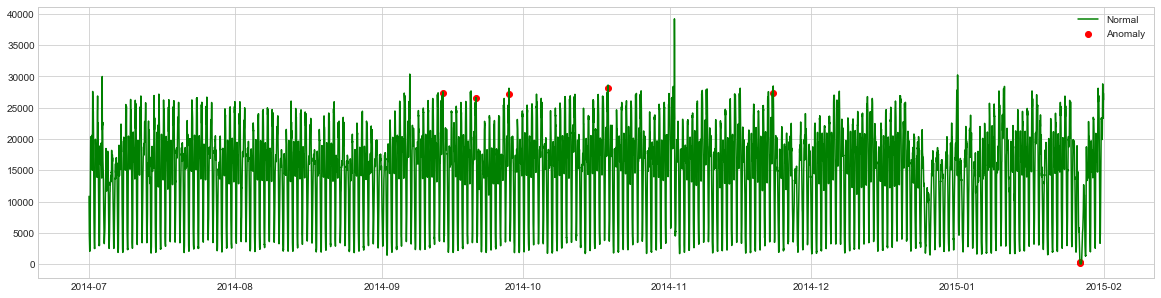

In [12]:
data = taxi
#I want to grab the top 0.001 outliars
#Since this data set is just >10,000 entries, I will capture 11 anomalies 
anomCount = 0.001

#Scale Data set
scaler = StandardScaler()
final = scaler.fit_transform(data)
data = pd.DataFrame(final)

#Train my model, using max_features 2
model =  IsolationForest(max_features=2, contamination=anomCount, behaviour="new", random_state=1)
model.fit(data)

# data
taxi['anomaly'] = model.predict(data)

# visualization
fig, ax = plt.subplots(figsize=(20, 5))

#Add an anomaly column to taxi with value (-1) when a value IS an anomaly 
anomalyList = taxi.loc[taxi['anomaly'] == -1, ['value']]

#Plot regular values, but treat anomalies as a scatter plot in a different color so they can be easily seen.
ax.plot(taxi.index, taxi['value'], color='green', label = 'Normal')
ax.scatter(anomalyList.index,anomalyList['value'], color='red', label = 'Anomaly')

plt.legend()
plt.show();

# Conclusion

In [13]:
anomalyList

,value
timestamp,
2014-09-14 00:00:00,27320
2014-09-21 00:00:00,26477
2014-09-28 00:00:00,27269
2014-10-19 00:00:00,28093
2014-11-23 00:00:00,27424
2015-01-26 23:00:00,297
2015-01-26 23:30:00,189


Of the anomalies detected, one of the was known beforehand. January 26th of 2015 was the date of the "North American Blizzard" so it makes sense that it was detected. Unfortunately, my model was not able to detect Christmas, New Years, or Thanksgiving. I suspect this is because as the holidays drew near, taxi usage went up gradually so there was no clear spike at any point in time on any of those 3 holidays. For example, it would reason that December 24th, 25th, and 26th would all have roughly the same taxi usage, so perhaps my model did not detect Christmas as an anomaly. The blizard, however was very localized, and caused anomalies to occur between the hours of 11pm January 26th 2015 and  midnight. This makes sense because if a blizzard hit the city hard it would cause a localized spike downward in taxi usage.